# Introduction
This project leverages the power of the scikit-surprise package to provide personalized book recommendations. [Surprise](https://surpriselib.com/) is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, KNNBasic, dump
from surprise.model_selection import GridSearchCV
from surprise import accuracy

In [2]:
df = pd.read_csv('book_rating.csv')

As surprise does not support implicit ratings, we need to remove the observations with 0 ratings.

In [3]:
df = df[df['Book-Rating'] != 0]

Also, to reduce the dimensionality and avoid extreme memory usage, we only keep the users that had rated more than 10 books, and books that have more than 10 ratings.

In [3]:
user_rating_count = df.groupby('User-ID')['Book-Rating'].count()
users_more_than_20_ratings = user_rating_count[user_rating_count > 10].index
df = df[df['User-ID'].isin(users_more_than_20_ratings)]

book_rating_count = df.groupby('ISBN')['Book-Rating'].count()
books_more_than_20_ratings = book_rating_count[book_rating_count > 10].index
df = df[df['ISBN'].isin(books_more_than_20_ratings)]

We start by defining a `Reader` object, specifying the rating scale for the dataset—ranging from 1 to 10 in this instance. Then we define a parameter grid for hyperparameter tuning through grid search. This grid encompasses options for baseline methods (`bsl_options`), the number of neighbors (`k`), and similarity options (`sim_options`) for the KNNBasic collaborative filtering algorithm.

In [15]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['User-ID', 'ISBN', 'Book-Rating']], reader=reader)

param_grid = {
    'bsl_options': {
        'method': ['als', 'sgd'],
        'reg': [1, 2],
    },
    'k': [2, 3, 4, 5],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'min_support': [1, 5],
        'user_based': [False],
    },
}

gs = GridSearchCV(KNNBasic, param_grid=param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

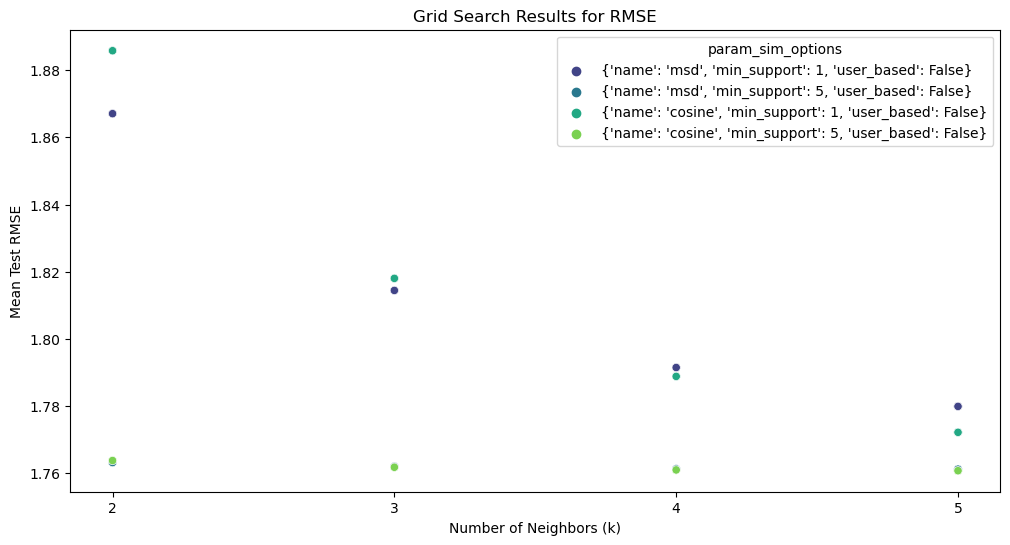

In [19]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df['param_sim_options'] = results_df['param_sim_options'].apply(str)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=results_df, x='param_k', y='mean_test_rmse', hue='param_sim_options', palette='viridis')
plt.title('Grid Search Results for RMSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test RMSE')
plt.locator_params(axis="x", integer=True, tight=True)
plt.show()

In [18]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.7607547809418662
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 5, 'sim_options': {'name': 'cosine', 'min_support': 5, 'user_based': False}}


Then, we use the best estimator to train the model with.

In [22]:
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [23]:
book_id = '0446607657'
item_inner_id = algo.trainset.to_inner_iid(book_id)
neighbors = algo.get_neighbors(item_inner_id, k=5)

suggested_book_ids = [algo.trainset.to_raw_iid(inner_id) for inner_id in neighbors]

for suggested_book_id in suggested_book_ids:
    title = df.loc[df['ISBN'] == suggested_book_id, 'Book-Title'].values
    print(title[0])